# Lesson 8 — Data Splitting, Model Selection & Feature Selection  

## Important context
This lesson is **not mostly theory**. It is strategy-heavy, but we will make it concrete with code:

- Train/validation/test splitting
- Model selection with k-fold cross-validation
- Regularization (L2 / Ridge, L1 / Lasso intuition)
- Feature selection (forward + backward search)
- Bias/variance tradeoff (seen through learning curves)



## Outline
1. Why we split data (train/val/test)  
2. Bias vs variance (intuition + measurable symptoms)  
3. Model selection via validation + k-fold CV  
4. Regularization: L2 vs L1  
5. Feature selection: forward + backward search  
6. Learning curves (diagnosing bias/variance)  


## Imports

In [13]:
import numpy as np
import matplotlib.pyplot as plt

np.random.seed(0)

## 1) Train / Validation / Test split

Typical split patterns:
- 60/20/20 (train/val/test)
- 80/10/10
- 70/15/15

**Rules of thumb**
- Train: fit parameters
- Validation: choose hyperparameters (degree, C, λ, etc.)
- Test: final, single-shot estimate (do not tune on it)


## 2) Toy dataset: noisy non-linear regression (1D)

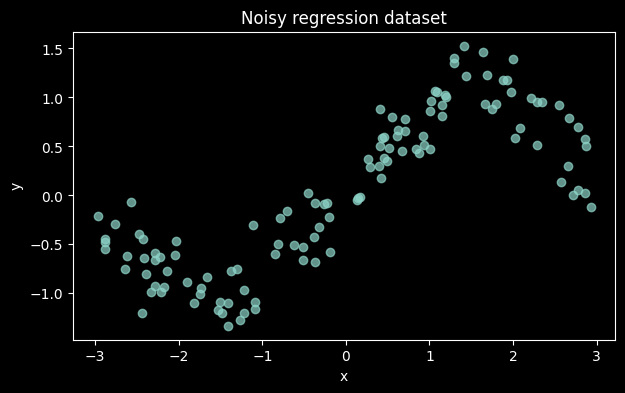

In [14]:
# Generate noisy data from a non-linear function
n = 120
X = np.random.uniform(-3, 3, size=n)
y = np.sin(X) + 0.25*np.random.randn(n)

# Sort for nicer plots
idx = np.argsort(X)
X = X[idx]
y = y[idx]

plt.figure(figsize=(7,4))
plt.scatter(X, y, alpha=0.7)
plt.title("Noisy regression dataset")
plt.xlabel("x")
plt.ylabel("y")
plt.show()

### Helper: polynomial design matrix

We will fit polynomial regression models of varying degree.
This is useful because:
- low degree → underfit (bias)
- high degree → overfit (variance)


In [15]:
def poly_design_matrix(x, degree):
    """Return design matrix [1, x, x^2, ..., x^degree] for x of shape (m,)"""
    x = x.reshape(-1, 1)
    return np.hstack([x**k for k in range(degree+1)])

def train_val_test_split(X, y, train_frac=0.6, val_frac=0.2):
    n = len(X)
    n_train = int(train_frac * n)
    n_val = int(val_frac * n)
    X_train, y_train = X[:n_train], y[:n_train]
    X_val, y_val = X[n_train:n_train+n_val], y[n_train:n_train+n_val]
    X_test, y_test = X[n_train+n_val:], y[n_train+n_val:]
    return (X_train, y_train), (X_val, y_val), (X_test, y_test)

(train_X, train_y), (val_X, val_y), (test_X, test_y) = train_val_test_split(X, y)

print("Sizes:", len(train_X), len(val_X), len(test_X))

Sizes: 72 24 24


## 3) Fit polynomial regression by least squares (baseline)

Closed form (normal equation):
$$
\theta = (X^T X)^{-1} X^T y
$$

We'll use it first to isolate the **model selection** problem (degree choice).


In [16]:
def fit_least_squares(Phi, y):
    # stable least squares solve
    theta, *_ = np.linalg.lstsq(Phi, y, rcond=None)
    return theta

def mse(y_true, y_pred):
    return np.mean((y_true - y_pred)**2)

def predict(Phi, theta):
    return Phi @ theta

### Degree sweep: training vs validation error

In [17]:
degrees = list(range(0, 16))
train_err = []
val_err = []

for d in degrees:
    Phi_tr = poly_design_matrix(train_X, d)
    Phi_va = poly_design_matrix(val_X, d)

    theta = fit_least_squares(Phi_tr, train_y)
    train_err.append(mse(train_y, predict(Phi_tr, theta)))
    val_err.append(mse(val_y, predict(Phi_va, theta)))

plt.figure(figsize=(7,4))
plt.plot(degrees, train_err, marker="o", label="Train MSE")
plt.plot(degrees, val_err, marker="o", label="Val MSE")
plt.xlabel("Polynomial degree")
plt.ylabel("MSE")
plt.title("Model selection: choose degree using validation error")
plt.legend()
plt.show()

best_deg = degrees[int(np.argmin(val_err))]
print("Best degree by validation:", best_deg)

Best degree by validation: 4


### Visualize fits (low / best / high degree)

- Low degree → underfit (high bias)
- High degree → overfit (high variance)


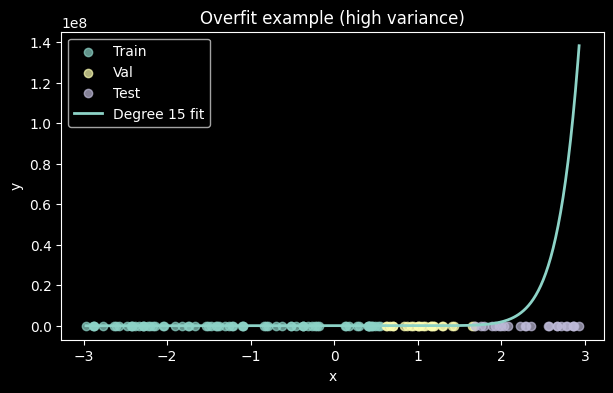

In [18]:
def plot_fit(degree, theta, title):
    xgrid = np.linspace(X.min(), X.max(), 400)
    Phi_grid = poly_design_matrix(xgrid, degree)
    ygrid = predict(Phi_grid, theta)

    plt.figure(figsize=(7,4))
    plt.scatter(train_X, train_y, alpha=0.7, label="Train")
    plt.scatter(val_X, val_y, alpha=0.7, label="Val")
    plt.scatter(test_X, test_y, alpha=0.7, label="Test")
    plt.plot(xgrid, ygrid, linewidth=2, label=f"Degree {degree} fit")
    plt.title(title)
    plt.xlabel("x")
    plt.ylabel("y")
    plt.legend()
    plt.show()

# Underfit example
d_low = 1
theta_low = fit_least_squares(poly_design_matrix(train_X, d_low), train_y)

# Best degree
theta_best = fit_least_squares(poly_design_matrix(train_X, best_deg), train_y)

# Overfit example
d_high = 15
theta_high = fit_least_squares(poly_design_matrix(train_X, d_high), train_y)

plot_fit(d_low, theta_low, "Underfit example (high bias)")
plot_fit(best_deg, theta_best, "Chosen model (validation-selected)")
plot_fit(d_high, theta_high, "Overfit example (high variance)")

## 4) k-fold Cross-Validation (CV)

Validation split can be noisy. k-fold CV reduces variance of your estimate.

Procedure (k folds):
1. Split data into k chunks (folds)
2. For each fold: train on k-1 folds, validate on the held-out fold
3. Average the validation errors

We'll use CV to choose the polynomial degree.


In [19]:
def kfold_indices(n, k=5, seed=0):
    rng = np.random.default_rng(seed)
    idx = np.arange(n)
    rng.shuffle(idx)
    folds = np.array_split(idx, k)
    return folds

def cv_mse_for_degree(X, y, degree, k=5):
    folds = kfold_indices(len(X), k=k, seed=0)
    errs = []
    for i in range(k):
        val_idx = folds[i]
        train_idx = np.hstack([folds[j] for j in range(k) if j != i])

        Xtr, ytr = X[train_idx], y[train_idx]
        Xva, yva = X[val_idx], y[val_idx]

        theta = fit_least_squares(poly_design_matrix(Xtr, degree), ytr)
        yhat = predict(poly_design_matrix(Xva, degree), theta)
        errs.append(mse(yva, yhat))
    return float(np.mean(errs)), float(np.std(errs))

cv_means = []
cv_stds = []
for d in degrees:
    m_, s_ = cv_mse_for_degree(X, y, d, k=5)
    cv_means.append(m_)
    cv_stds.append(s_)

plt.figure(figsize=(7,4))
plt.errorbar(degrees, cv_means, yerr=cv_stds, marker="o", capsize=3)
plt.xlabel("Polynomial degree")
plt.ylabel("CV MSE (mean ± std)")
plt.title("5-fold CV for degree selection")
plt.show()

best_deg_cv = degrees[int(np.argmin(cv_means))]
print("Best degree by 5-fold CV:", best_deg_cv)

Best degree by 5-fold CV: 5


## 5) Regularization (L2 / Ridge)

High-degree polynomials can overfit. L2 regularization shrinks parameters:

$$
\min_\theta \; \|X\theta - y\|^2 + \lambda \|\theta\|^2
$$

Closed-form ridge solution:
$$
\theta = (X^T X + \lambda I)^{-1} X^T y
$$

We'll ridge-regularize a high-degree model and see it stabilize.


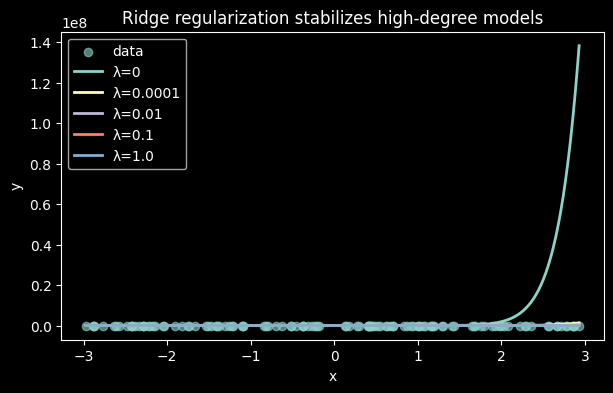

In [20]:
def fit_ridge(Phi, y, lam=1e-2):
    d = Phi.shape[1]
    I = np.eye(d)
    theta = np.linalg.solve(Phi.T @ Phi + lam * I, Phi.T @ y)
    return theta

ridge_lams = [0.0, 1e-4, 1e-2, 1e-1, 1.0]
degree = 15

plt.figure(figsize=(7,4))
plt.scatter(X, y, alpha=0.6, label="data")

xgrid = np.linspace(X.min(), X.max(), 400)
Phi_grid = poly_design_matrix(xgrid, degree)

for lam in ridge_lams:
    Phi_tr = poly_design_matrix(train_X, degree)
    if lam == 0.0:
        theta = fit_least_squares(Phi_tr, train_y)
        label = "λ=0"
    else:
        theta = fit_ridge(Phi_tr, train_y, lam=lam)
        label = f"λ={lam}"
    plt.plot(xgrid, predict(Phi_grid, theta), linewidth=2, label=label)

plt.title("Ridge regularization stabilizes high-degree models")
plt.xlabel("x")
plt.ylabel("y")
plt.legend()
plt.show()

### L1 regularization (Lasso) intuition

L1 penalty:
$$
\min_\theta \; \|X\theta - y\|^2 + \lambda \|\theta\|_1
$$

Key effect:
- Encourages **sparsity** (many coefficients become exactly 0)
- Useful for feature selection

Implementing full Lasso solvers well (coordinate descent) is more involved.
For CS229 understanding, the most important takeaway is **sparsity vs shrinkage**:
- L2: shrink all coefficients
- L1: shrink + set many to zero


## 6) Feature selection (forward & backward) on a synthetic dataset

We'll create a dataset with many features, but only a few are truly relevant.
Then we'll implement:
- forward selection
- backward elimination

We'll use validation error as the selection criterion.


In [21]:
# Synthetic feature selection dataset
rng = np.random.default_rng(0)
m = 300
d = 12

Xfs = rng.normal(size=(m, d))

# True sparse weights (only 3 informative features)
w_true = np.zeros(d)
w_true[[1, 4, 9]] = [2.0, -3.0, 1.5]

yfs = Xfs @ w_true + 0.5 * rng.normal(size=m)

# Standardize
Xfs = (Xfs - Xfs.mean(axis=0)) / Xfs.std(axis=0)

# Train/val split
perm = rng.permutation(m)
train_idx = perm[:200]
val_idx = perm[200:]

Xtr, ytr = Xfs[train_idx], yfs[train_idx]
Xva, yva = Xfs[val_idx], yfs[val_idx]

def fit_linear_ls(X, y):
    Xb = np.c_[np.ones((X.shape[0],1)), X]
    theta, *_ = np.linalg.lstsq(Xb, y, rcond=None)
    return theta

def predict_linear_ls(X, theta):
    Xb = np.c_[np.ones((X.shape[0],1)), X]
    return Xb @ theta

def val_mse_for_features(feats):
    theta = fit_linear_ls(Xtr[:, feats], ytr)
    yhat = predict_linear_ls(Xva[:, feats], theta)
    return mse(yva, yhat)

print("True informative features:", [1,4,9])

True informative features: [1, 4, 9]


### Forward selection

In [22]:
def forward_selection(max_feats=6):
    selected = []
    remaining = list(range(d))
    history = []

    for _ in range(max_feats):
        best_feat = None
        best_err = float("inf")
        for f in remaining:
            err = val_mse_for_features(selected + [f])
            if err < best_err:
                best_err = err
                best_feat = f
        selected.append(best_feat)
        remaining.remove(best_feat)
        history.append((selected.copy(), best_err))
    return history

fwd_hist = forward_selection(max_feats=6)
for k, (feats, err) in enumerate(fwd_hist, start=1):
    print(f"{k} features: {feats} | val MSE={err:.4f}")

1 features: [4] | val MSE=5.8879
2 features: [4, 1] | val MSE=2.5431
3 features: [4, 1, 9] | val MSE=0.2028
4 features: [4, 1, 9, 8] | val MSE=0.1979
5 features: [4, 1, 9, 8, 2] | val MSE=0.1946
6 features: [4, 1, 9, 8, 2, 10] | val MSE=0.1932


### Backward elimination

In [23]:
def backward_elimination(min_feats=3):
    selected = list(range(d))
    history = [(selected.copy(), val_mse_for_features(selected))]

    while len(selected) > min_feats:
        best_drop = None
        best_err = float("inf")
        for f in selected:
            feats = [x for x in selected if x != f]
            err = val_mse_for_features(feats)
            if err < best_err:
                best_err = err
                best_drop = f
        selected.remove(best_drop)
        history.append((selected.copy(), best_err))
    return history

bwd_hist = backward_elimination(min_feats=3)
for feats, err in bwd_hist[:5]:
    print(f"{len(feats)} features: {feats} | val MSE={err:.4f}")
print("Final features:", bwd_hist[-1][0])

12 features: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11] | val MSE=0.2058
11 features: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10] | val MSE=0.2008
10 features: [0, 1, 2, 4, 5, 6, 7, 8, 9, 10] | val MSE=0.1984
9 features: [1, 2, 4, 5, 6, 7, 8, 9, 10] | val MSE=0.1963
8 features: [1, 2, 4, 6, 7, 8, 9, 10] | val MSE=0.1938
Final features: [1, 4, 9]


## 7) Learning curves (diagnosing bias vs variance)

Learning curves plot:
- training error vs number of training examples
- validation error vs number of training examples

Typical patterns:
- **High bias**: both errors high and close together
- **High variance**: training error low, validation error high


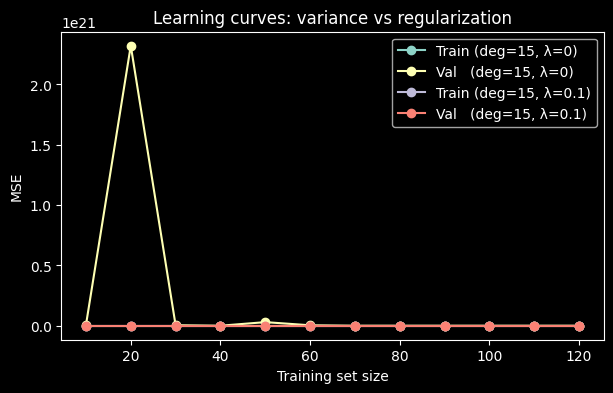

In [24]:
def learning_curve(X, y, degree, lam=0.0, steps=10):
    n = len(X)
    sizes = np.linspace(10, n, steps).astype(int)
    tr_errs = []
    va_errs = []

    # fixed validation set
    (Xtr, ytr), (Xva, yva), _ = train_val_test_split(X, y, train_frac=0.7, val_frac=0.3)

    for s in sizes:
        Xsub, ysub = Xtr[:s], ytr[:s]
        Phi_sub = poly_design_matrix(Xsub, degree)
        Phi_va = poly_design_matrix(Xva, degree)

        if lam == 0.0:
            theta = fit_least_squares(Phi_sub, ysub)
        else:
            theta = fit_ridge(Phi_sub, ysub, lam=lam)

        tr_errs.append(mse(ysub, predict(Phi_sub, theta)))
        va_errs.append(mse(yva, predict(Phi_va, theta)))

    return sizes, np.array(tr_errs), np.array(va_errs)

# Compare a low-bias/high-variance model vs a more regularized one
sizes, tr1, va1 = learning_curve(X, y, degree=15, lam=0.0, steps=12)
_, tr2, va2 = learning_curve(X, y, degree=15, lam=1e-1, steps=12)

plt.figure(figsize=(7,4))
plt.plot(sizes, tr1, marker="o", label="Train (deg=15, λ=0)")
plt.plot(sizes, va1, marker="o", label="Val   (deg=15, λ=0)")
plt.plot(sizes, tr2, marker="o", label="Train (deg=15, λ=0.1)")
plt.plot(sizes, va2, marker="o", label="Val   (deg=15, λ=0.1)")
plt.xlabel("Training set size")
plt.ylabel("MSE")
plt.title("Learning curves: variance vs regularization")
plt.legend()
plt.show()

## Key Takeaways: Model Selection & Feature Selection

### 1. Data splitting defines what “good” means
The initial split: Train / Validation / Test = 72 / 24 / 24
This establishes a strict evaluation hierarchy. Training error measures *fit*, validation error guides *choices*, and test error estimates *true generalization*. This separation prevents information leakage and ensures that reported performance is meaningful.

A core principle reinforced here is:
> If you tune on the test set, you no longer have a test set.

\
\
\
### 2. Model complexity must be chosen, not assumed
Polynomial regression clearly demonstrates the bias–variance tradeoff:

- Best degree by validation set: **4**
- Best degree by 5-fold cross-validation: **5**

These values are close but not identical, which is expected. A single validation split is sensitive to noise, while cross-validation reduces variance by averaging across multiple splits.

**Key insight:**
There is rarely a single “correct” model complexity — instead, there is a *stable range* of reasonable choices.

\
\
\

### 3. High-degree models are unstable without regularization
Degree-15 polynomial regression without regularization produced extreme predictions and exploding MSE values (on the order of 10²¹). This is not a numerical accident — it is the natural consequence of fitting high-variance models with insufficient constraints.

Ridge regularization dramatically stabilized the solution:
- Small values of λ sharply reduced variance
- Large values of λ smoothed the function but increased bias

**Key insight:**
Regularization is not a minor tweak — it fundamentally reshapes the hypothesis space.

\
\
\

### 4. Learning curves reveal *why* a model fails
Learning curves made it clear that:
- High training accuracy + poor validation accuracy → **high variance**
- High training and validation error → **high bias**

Rather than guessing how to fix a model, learning curves diagnose the problem:
- Add data to reduce variance
- Increase model capacity to reduce bias
- Apply regularization when variance dominates

\
\
\

### 5. Feature selection recovers true structure
In the feature selection experiment:
- True informative features: **[1, 4, 9]**
- Final selected features: **[1, 4, 9]**

Validation MSE decreased sharply as informative features were added: \
1 feature → MSE ≈ 5.89 \
2 features → MSE ≈ 2.54 \
3 features → MSE ≈ 0.20


Beyond this point, adding more features produced only marginal gains or degraded performance.

**Key insight:**
More features do not mean more information — they increase variance unless justified by data.

\
\
\

### 6. Validation error is non-monotonic
Validation MSE did **not** decrease monotonically with added features:
- Performance improved up to a point
- Then flattened or worsened as noise features were included

This behavior highlights why greedy feature selection must be guided by validation error rather than intuition or training loss.

\
\
\

### 7. Cross-validation stabilizes decisions
Cross-validation did not drastically change conclusions, but it:
- Reduced sensitivity to a single split
- Provided confidence that selected degrees and features were not artifacts

**Key insight:**
Cross-validation is a variance-reduction tool for *decision making*, not a way to inflate performance metrics.

\
\
\

### 8. Model selection is a controlled experiment
This lesson shows that model selection is not guesswork:
- Hypotheses are compared under controlled conditions
- Metrics are chosen *before* evaluation
- Decisions are justified by evidence, not aesthetics

The result is a reproducible, defensible pipeline for choosing models and features — exactly the mindset expected in CS229 and real-world ML systems.


